In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyviper
import os

import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
    
from scGraphLLM.eval_config import IMMUNE_CELL_TYPES

REG_VALS = "regulator.values"
TAR_VALS = "target.values"
LOGP_VALS = "log.p.values"


human_immune_cells = [
    'CD4+ T cells',
    'CD14+ Monocytes',
    'CD20+ B cells',
    'NKT cells',
    'NK cells',
    'CD8+ T cells',
    'Erythrocytes',
    'Monocyte-derived dendritic cells',
    'CD16+ Monocytes',
    # 'HSPCs',
    # 'Erythroid progenitors',
    # 'Plasmacytoid dendritic cells',
    # 'Monocyte progenitors',
    # 'Megakaryocyte progenitors',
    # 'CD10+ B cells',
    # 'Plasma cells'
]

In [2]:
aracne_path_format = "/hpc/mydata/rowan.cassius/data/scGPT/human_immune/cell_type/{}/aracne_4096/consolidated-net_defaultid.tsv"
cells_path_format = "/hpc/mydata/rowan.cassius/data/scGPT/human_immune/cell_type/{}/cells.h5ad"

In [3]:
n = 1000
cells_list = []
for cell_type in IMMUNE_CELL_TYPES:
    cells_path = cells_path_format.format(cell_type)
    cells = sc.read_h5ad(cells_path)
    if cells.n_obs > n:
        sc.pp.subsample(cells, n_obs=n, random_state=12345, copy=False)
    cells_list.append(cells)

In [4]:
adata = ad.concat(cells_list, join='outer', axis=0)
# assign train/test
adata.obs["set"] = np.where(np.random.rand(adata.obs.shape[0]) < 0.2, 'test', 'train')

In [5]:
adata

AnnData object with n_obs × n_vars = 8972 × 11971
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'cluster', 'set'
    obsm: 'X_pca'
    layers: 'counts'

In [6]:
sc.tl.pca(adata, svd_solver='arpack', random_state=12345)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Text(0.5, 1.0, 'Human Immune Cells Dataset')

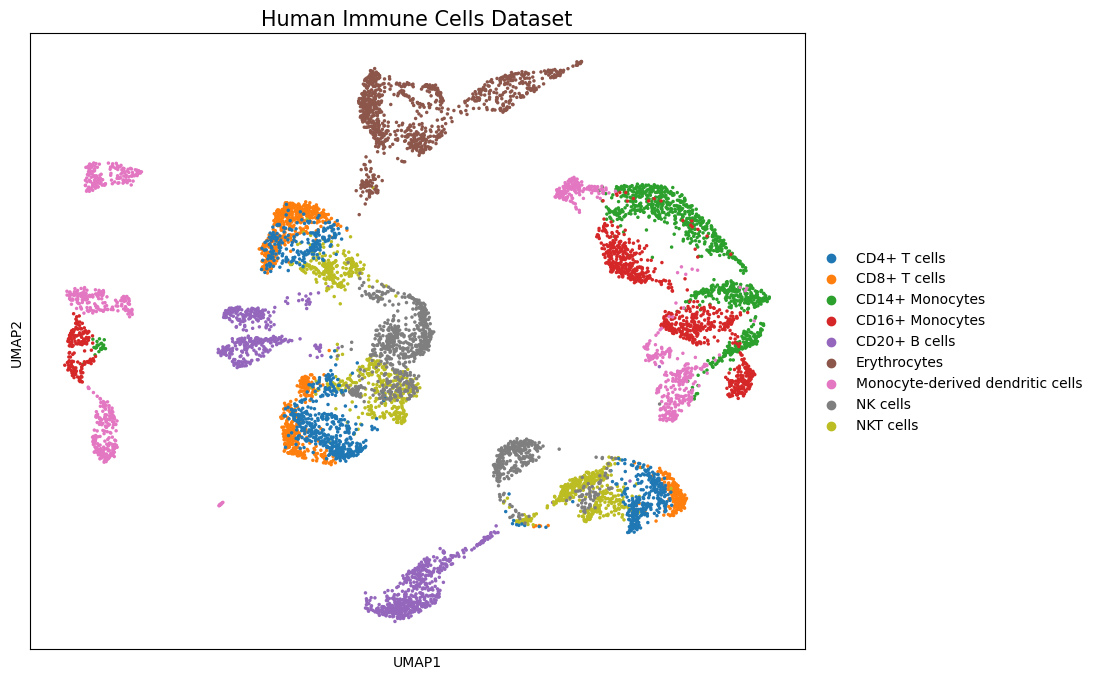

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(adata, color="final_annotation", ax=ax, size=25, show=False)
ax.set_title("Human Immune Cells Dataset", fontsize=15)

Text(0.5, 1.0, 'Human Immune Cells Dataset')

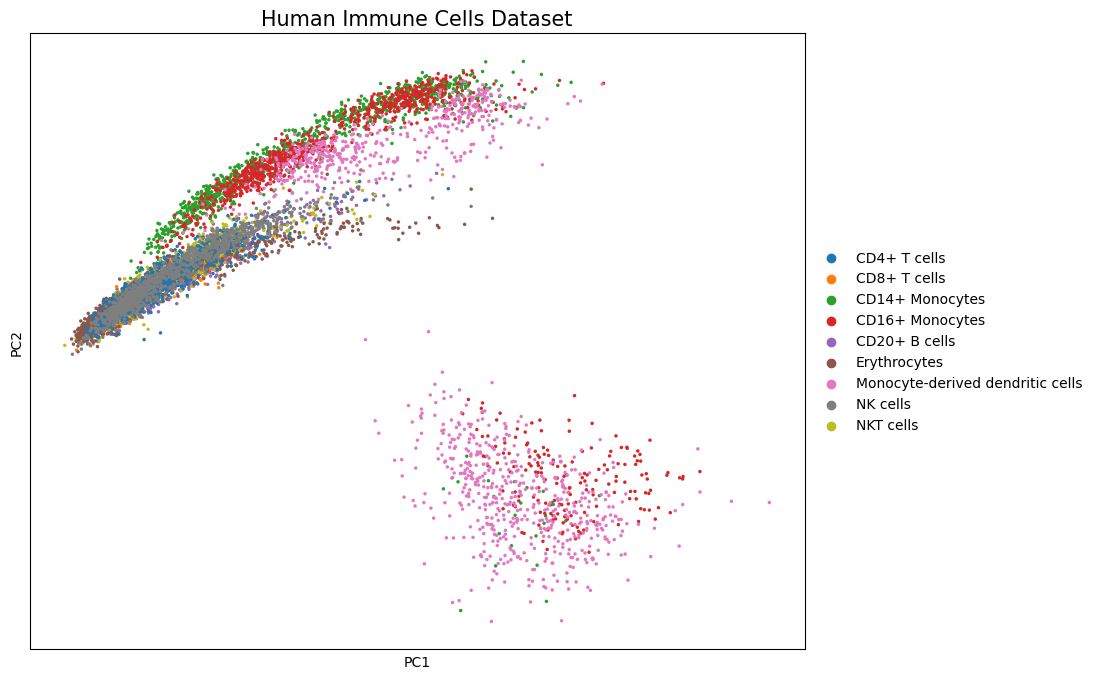

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.pca(adata, color="final_annotation", ax=ax, size=25, show=False)
ax.set_title("Human Immune Cells Dataset", fontsize=15)

In [12]:
train = adata[adata.obs["set"] == "train",:]
test = adata[adata.obs["set"] == "test",:]

In [10]:
train.shape

(7164, 11971)

In [11]:
test.shape

(1808, 11971)

In [18]:
X_train = train.obsm["X_pca"]
y_train = train.obs["final_annotation"]
X_test = test.obsm["X_pca"]
y_test = test.obs["final_annotation"]

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))

pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

Accuracy: 0.9413716814159292


,precision,recall,f1-score,support
CD14+ Monocytes,0.983607,0.978261,0.980926,184.000000
CD16+ Monocytes,0.989189,0.989189,0.989189,185.000000
CD20+ B cells,1.000000,1.000000,1.000000,194.000000
CD4+ T cells,0.884817,0.793427,0.836634,213.000000
CD8+ T cells,0.849785,0.942857,0.893905,210.000000
Erythrocytes,1.000000,1.000000,1.000000,210.000000
Monocyte-derived dendritic cells,0.995074,0.995074,0.995074,203.000000
NK cells,0.954802,0.866667,0.908602,195.000000
NKT cells,0.849138,0.920561,0.883408,214.000000
accuracy,0.941372,0.941372,0.941372,0.941372


In [19]:
yhat_train = knn.predict(X_train)

# Evaluate
print("Accuracy:", accuracy_score(y_train, yhat_train))

pd.DataFrame(classification_report(y_train, yhat_train, output_dict=True)).T

Accuracy: 1.0


,precision,recall,f1-score,support
CD14+ Monocytes,1.0,1.0,1.0,816.0
CD16+ Monocytes,1.0,1.0,1.0,787.0
CD20+ B cells,1.0,1.0,1.0,806.0
CD4+ T cells,1.0,1.0,1.0,787.0
CD8+ T cells,1.0,1.0,1.0,790.0
Erythrocytes,1.0,1.0,1.0,790.0
Monocyte-derived dendritic cells,1.0,1.0,1.0,797.0
NK cells,1.0,1.0,1.0,805.0
NKT cells,1.0,1.0,1.0,786.0
accuracy,1.0,1.0,1.0,1.0


In [ ]:
# adata.write_h5ad("/hpc/mydata/rowan.cassius/data/scGPT/human_immune/processed_human_immune.h5ad")

In [21]:
X = adata.obsm["X_pca"]
X_probs = knn.predict_proba(X)  # shape: (n_cells, n_classes)
X_train_probs = knn.predict_proba(X_train)
X_test_probs = knn.predict_proba(X_test)

# View class order
print("Class order:", knn.classes_)

Class order: ['CD14+ Monocytes' 'CD16+ Monocytes' 'CD20+ B cells' 'CD4+ T cells'
 'CD8+ T cells' 'Erythrocytes' 'Monocyte-derived dendritic cells'
 'NK cells' 'NKT cells']


In [27]:
pd.Series([len(p[p > 0]) for p in X_train_probs]).value_counts(normalize=True)

1    0.868649
2    0.120743
3    0.010190
4    0.000419
Name: proportion, dtype: float64

In [ ]:
pd.Series([len(p[p > 0]) for p in X_test_probs]).value_counts(normalize=True)

1    0.793695
2    0.184181
3    0.020465
4    0.001659
Name: proportion, dtype: float64

In [30]:
X_test_probs[:5,:]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.2153465 , 0.        , 0.        , 0.39410891, 0.19493987,
        0.        , 0.        , 0.        , 0.19560472],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [31]:
adata.obsm["class_probs"] = X_probs

In [32]:
adata.uns["class_probs_names"] = knn.classes_

In [1]:
# adata.write_h5ad("/hpc/mydata/rowan.cassius/data/scGPT/human_immune/processed_human_immune.h5ad")

import scanpy as sc
adata = sc.read_h5ad("/hpc/mydata/rowan.cassius/data/scGPT/human_immune/processed_human_immune.h5ad")

In [2]:
adata.uns["class_probs_names"]

array(['CD14+ Monocytes', 'CD16+ Monocytes', 'CD20+ B cells',
       'CD4+ T cells', 'CD8+ T cells', 'Erythrocytes',
       'Monocyte-derived dendritic cells', 'NK cells', 'NKT cells'],
      dtype=object)

In [3]:
adata.obsm["class_probs"]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
adata.uns["class_probs_names"][adata.obsm["class_probs"].argmax(axis=1)]

(8972,)

In [4]:
adata_sample = sc.pp.subsample(adata, n_obs=200, copy=True)

In [6]:
adata_sample.write_h5ad("/hpc/mydata/rowan.cassius/data/scGPT/human_immune/processed_human_immune_sample.h5ad")